# Задание

Проанализировать данные из датасета, провести их очистку (вплоть до удаления записей) и построить классификатор, что будет наилучшим образом (и равномерно) предсказывать классы.
* Финальный macro F-score не должен быть ниже 0.55.
* При удалении элементов из датасета, в нём должно остаться не менее 20 000 сэмплов.

# Настройки/Импорты

Версии важных модулей:
* pandas==2.1.1
* numpy==1.26.2
* torch==1.13.0+cu117
* matplotlib==3.6.2

In [1]:
# !pip install pandarallel==1.6.5
# !pip install pymorphy3==1.2.0
# !pip install torcheval

# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

In [1]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import psutil # для просмотра числа потоков на cpu
from pandarallel import pandarallel # для параллельного запуска кода на cpu
from tqdm.auto import tqdm # для отслеживания прогресса
from typing import Iterable # для параметра функции, по которому можно итерироваться
import pickle # для сохранения и загрузки объектов

from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # для токенизации строк
from pymorphy3 import MorphAnalyzer # для работы со словами (лемматизация, часть речи...)
from sklearn.utils import resample # для upsample и downsample данных (выравнивание классов)
from sklearn.model_selection import train_test_split # для разбиения на обучающую и тестовую выборку

from torch.utils.data import Dataset, DataLoader # для создания torch датасета и загрузчика данных
from transformers import AutoTokenizer, AutoConfig, AutoModel, AutoModelForSequenceClassification # для работы с Hugging Face моделями
import torch.nn as nn # для слоёв torch нейронки 
import torch # для работы с моделями torch

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков
from wordcloud import WordCloud # для построения изображения с самыми часто встречаемыми словами (помогает в определении дополнительных стоп-слов)
from torcheval.metrics.functional import multiclass_f1_score # дополнительные метрики
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # для оценки качества предсказаний

c:\Users\User\anaconda3\envs\gpu\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
DATA_DIR = "./data/" # путь до папки с данными
MODELS_DIR = "./models/" # путь до папки с моделями
DATA_COL = "text" # столбец, отвечающий за входные данные
TARGET_COL = "tag" # столбец, отвечающий за таргеты
RANDOM_STATE = 42 # число для задания случайности
DTYPE = np.float32 # используемый тип

ADD_STOP_WORDS = [",", ".", "...", "?", "!", ":", "-", "(", ")", "``", "''", "Я", "Вы", "это", "И", "А", "Но", "очень", "просто", "нужно"] # дополнительные стоп-слова
MAX_SEQUENCE_LEN = 100 # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation), определялось по гистограмме распределения числа токенов в текстах
SAMPLES_PER_CLASS = 5000 # сколько должно быть сэмплов в каждом классе (None для выравнивания по наиболее представленному классу)
TEST_SIZE = 0.2 # размер тестовой выборки

TOKENIZER_NAME = "cointegrated/rubert-tiny-toxicity" # наименование токенизатора на Hugging Face
MODEL_NAME = "cointegrated/rubert-tiny-toxicity" # наименование модели на Hugging Face

EPOCHS_PATIENCE = 5 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
EPOCHS = 50 # число эпох обучения
LEARNING_RATE = 0.0001 # learning rate
BATCH_SIZE = 50 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

In [3]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Девайс: {DEVICE}.")

Девайс: cuda:0.


In [4]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False)) # число доступных потоков

Количество доступных потоков:  4


In [6]:
# from google.colab import drive # для Google Drive
# drive.mount('/content/drive') # подключаемся к Google Drive

# # перезаписываем важные переменные
# DATA_DIR = "/content/drive/MyDrive/tmp/data/" # путь до папки с данными
# MODELS_DIR = "/content/drive/MyDrive/tmp/models/" # путь до папки с моделями

# Предобработка датасета

In [7]:
dataset = pd.read_csv(f"{DATA_DIR}Data_Sources.csv", sep=";", encoding="UTF-8") # считывание данных в формате csv, разделённых с помощью символа sep и закодированных в encoding (можно проверить с помощью Notepad++, тип кодировки будет справа снизу)
dataset

,url,date,text,tag,source
0,https://vk.com/club3291025?w=wall-3291025_1020782,2023-04-15 19:39,Всем добрый день! У меня БАР 2 типа. Начала ч...,БАР,ВК
1,https://vk.com/id32362343,2023-04-15 19:46,это на всякий случай?,БАР,ВК
2,https://vk.com/id415411329,2023-04-15 19:44,Попробуйте успокоиться. Сделайте выводы. Приго...,БАР,ВК
3,https://vk.com/id777797099,2023-04-15 19:44,На все вопросы вы ответили сами.,БАР,ВК
4,https://vk.com/id739587393,2023-04-15 19:47,"Всё к лучшему. Если вы так сделали, значит так...",БАР,ВК
...,...,...,...,...,...
66455,https://vk.com/id19312999,2019-04-02 9:03,https://pcixi.ru/forum/88-9302-1 Исцеление люб...,шизофрения,ВК
66456,https://vk.com/id19312999,2019-04-02 10:35,не лечится анамалия развития? То есть если я с...,шизофрения,ВК
66457,https://vk.com/id19312999,2019-04-02 18:31,"благодарю за ответ. Спасибо, я почитаю про шиз...",шизофрения,ВК
66458,https://vk.com/id293789448,2019-04-02 22:17,"в церковь ходили, батюшка лет 20 назад очень п...",шизофрения,ВК


Изначальное распределение лейблов в датасете.

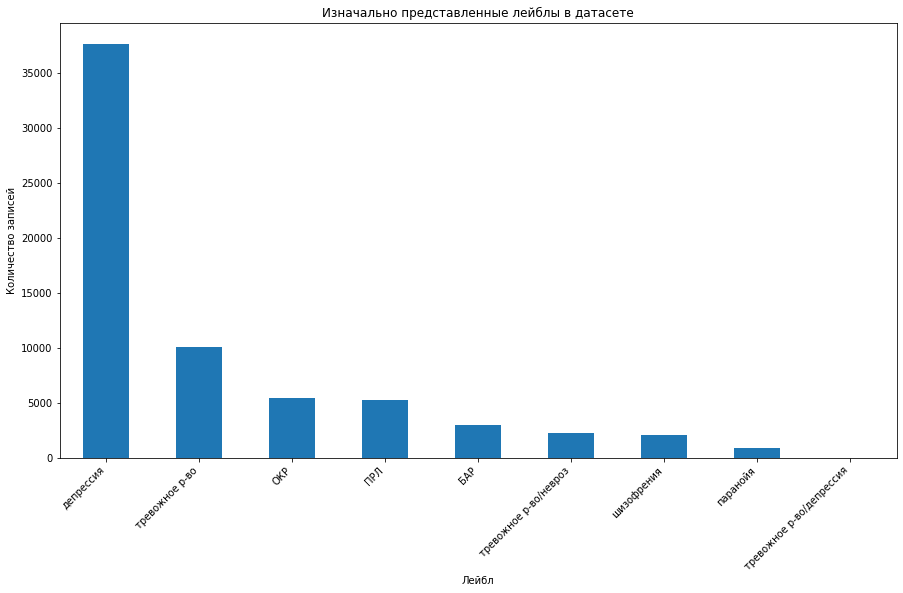

In [8]:
plt.figure(figsize=(15,8)) # задание размера фигуры
dataset[TARGET_COL].value_counts().plot.bar() # построение столбчатой диаграммы по данным
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Изначально представленные лейблы в датасете") # название фигуры
plt.xlabel("Лейбл") # подпись по оси x
plt.ylabel("Количество записей") # подпись по оси y
plt.show() # показ фигуры

## Очистка датасета

### Удаляем или заменяем столбцы, что не несут полезную информацию.

In [9]:
dataset[TARGET_COL].replace("тревожное р-во/депрессия", "тревожное р-во", inplace=True) # заменяем все записи, что были малопредставлены на их аналог или None (для последующего удаления)
dataset[TARGET_COL].replace("тревожное р-во/невроз", "тревожное р-во", inplace=True) # заменяем все записи, что были малопредставлены на их аналог или None (для последующего удаления)
dataset[TARGET_COL].replace("паранойя", None, inplace=True) # заменяем все записи, что были малопредставлены на их аналог или None (для последующего удаления)
dataset.dropna(axis=0, inplace=True) # удаляем строки (axis=0), в которых есть пропущенные значения

dataset.drop(labels=["url", "date", "source"], axis=1, inplace=True) # удаляем ненужные столбцы (labels по axis=1) с перезаписью (inplace=True)

dataset

,text,tag
0,Всем добрый день! У меня БАР 2 типа. Начала ч...,БАР
1,это на всякий случай?,БАР
2,Попробуйте успокоиться. Сделайте выводы. Приго...,БАР
3,На все вопросы вы ответили сами.,БАР
4,"Всё к лучшему. Если вы так сделали, значит так...",БАР
...,...,...
66455,https://pcixi.ru/forum/88-9302-1 Исцеление люб...,шизофрения
66456,не лечится анамалия развития? То есть если я с...,шизофрения
66457,"благодарю за ответ. Спасибо, я почитаю про шиз...",шизофрения
66458,"в церковь ходили, батюшка лет 20 назад очень п...",шизофрения


### Удаляем стоп-слова и мусорные значения.

Считаем распределение токенов по датасету.

In [10]:
tokens_distribution = {} # словарь под распределение токенов по классам

dataset[DATA_COL] = dataset[DATA_COL].apply(lambda text: word_tokenize(text, language="russian")) # разбиваем текст на слова (токены)
for target_value in dataset[TARGET_COL].unique(): # идём по значениям таргетов
    tokens_distribution[target_value] = {} # словарь под слова с рассматриваемым таргетом
    for sequence in dataset[dataset[TARGET_COL] == target_value][DATA_COL]: # идём по записям (строкам в DataFrame, последовательностям токенов) с рассматриваемым таргетом
        for token in sequence: # идём по токенам в последовательности
            if token in tokens_distribution[target_value].keys(): # если токен уже был встречен в классе
                tokens_distribution[target_value][token] += 1
            else: # если токен встречается впервые
                tokens_distribution[target_value][token] = 1
tokens_distribution = pd.DataFrame(tokens_distribution) # собираем DataFrame на основе словаря
tokens_distribution.fillna(0, inplace=True) # пропущенные значения заполняем нулями - токен ни разу не встретился в таких записях

tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,7.0,45.0,9.0,14.0,19.0,3.0
добрый,6.0,129.0,17.0,17.0,42.0,6.0
день,94.0,1538.0,230.0,127.0,713.0,43.0
!,642.0,6089.0,785.0,838.0,1967.0,431.0
У,178.0,2101.0,305.0,302.0,639.0,144.0
...,...,...,...,...,...,...
незанятым,0.0,0.0,0.0,0.0,0.0,1.0
выметенным,0.0,0.0,0.0,0.0,0.0,1.0
убранным,0.0,0.0,0.0,0.0,0.0,1.0
злейших,0.0,0.0,0.0,0.0,0.0,1.0


Оставляем только те токены, что встречаются не слишком редко.

In [11]:
MIN_TOKEN_COUNT = 20 # минимальное число раз, сколько токен должен быть встречен
tokens_distribution = tokens_distribution[tokens_distribution.sum(axis=1) > MIN_TOKEN_COUNT] # оставляем только те токены, что встречались не менее MIN_TOKEN_COUNT раз
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,7.0,45.0,9.0,14.0,19.0,3.0
добрый,6.0,129.0,17.0,17.0,42.0,6.0
день,94.0,1538.0,230.0,127.0,713.0,43.0
!,642.0,6089.0,785.0,838.0,1967.0,431.0
У,178.0,2101.0,305.0,302.0,639.0,144.0
...,...,...,...,...,...,...
тонометр,0.0,0.0,0.0,0.0,25.0,0.0
Соня,0.0,0.0,0.0,0.0,31.0,0.0
тонометра,0.0,0.0,0.0,0.0,38.0,0.0
МП,0.0,0.0,0.0,0.0,29.0,0.0


Переходим к распределению токенов по классам.

In [12]:
target_count = dataset[TARGET_COL].value_counts() # число записей с определённым таргетом
for target_value in tokens_distribution.columns: # идём по значениям таргетов
    tokens_distribution[target_value] = tokens_distribution[target_value] / target_count[target_value] # считаем, насколько часто встречается токен среди записей по таргету

tokens_distribution

C:\Users\User\Documents\TEMP\ipykernel_5556\2366456831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokens_distribution[target_value] = tokens_distribution[target_value] / target_count[target_value] # считаем, насколько часто встречается токен среди записей по таргету


,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.002505,0.001201,0.001745,0.002683,0.001546,0.001460
добрый,0.002147,0.003442,0.003296,0.003257,0.003418,0.002920
день,0.033644,0.041041,0.044591,0.024334,0.058029,0.020925
!,0.229778,0.162482,0.152191,0.160567,0.160088,0.209732
У,0.063708,0.056064,0.059131,0.057865,0.052006,0.070073
...,...,...,...,...,...,...
тонометр,0.000000,0.000000,0.000000,0.000000,0.002035,0.000000
Соня,0.000000,0.000000,0.000000,0.000000,0.002523,0.000000
тонометра,0.000000,0.000000,0.000000,0.000000,0.003093,0.000000
МП,0.000000,0.000000,0.000000,0.000000,0.002360,0.000000


Стоп-слова.

In [14]:
# stop_words = [] # список стоп-слов
stop_words = stopwords.words('russian') # список стоп-слов для языка
for add_stop in ADD_STOP_WORDS: # идём по дополнительным стоп-словам
    stop_words.append(add_stop) # добавляем стоп-слово

tokens_distribution.loc[[token for token in stop_words if token in tokens_distribution.index]] # распределение стоп-слов в датасете

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
и,1.186113,1.359706,1.526367,1.260970,1.554651,1.340633
в,0.852899,0.959733,1.044397,0.889634,1.124440,0.918248
во,0.024696,0.032128,0.039550,0.029891,0.035647,0.023844
не,0.957767,1.104043,1.283637,1.063039,1.138602,1.217032
что,0.631711,0.795464,0.990694,0.779843,0.844795,0.674453
...,...,...,...,...,...,...
А,0.130995,0.137852,0.174486,0.151370,0.170261,0.171776
Но,0.094488,0.097612,0.153742,0.125695,0.118825,0.102676
очень,0.100573,0.117759,0.121753,0.141406,0.132986,0.103650
просто,0.061918,0.099320,0.121753,0.096762,0.097990,0.092457


In [15]:
tokens_distribution = tokens_distribution.loc[[token for token in tokens_distribution.index if token not in stop_words]] # удаляем стоп-слова
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.002505,0.001201,0.001745,0.002683,0.001546,0.001460
добрый,0.002147,0.003442,0.003296,0.003257,0.003418,0.002920
день,0.033644,0.041041,0.044591,0.024334,0.058029,0.020925
У,0.063708,0.056064,0.059131,0.057865,0.052006,0.070073
БАР,0.077309,0.001094,0.000000,0.002683,0.000326,0.000487
...,...,...,...,...,...,...
тонометр,0.000000,0.000000,0.000000,0.000000,0.002035,0.000000
Соня,0.000000,0.000000,0.000000,0.000000,0.002523,0.000000
тонометра,0.000000,0.000000,0.000000,0.000000,0.003093,0.000000
МП,0.000000,0.000000,0.000000,0.000000,0.002360,0.000000


Удаляем слова, что даже в классах встречаются слишком редко.

In [16]:
MIN_TOKEN_DISTRIBUTION = 0.001 # минимальное частота использования токена
tokens_distribution = tokens_distribution[tokens_distribution.max(axis=1) > MIN_TOKEN_DISTRIBUTION] # оставляем только те строки, у которых частота использования слова по классу не менее MIN_TOKEN_DISTRIBUTION
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.002505,0.001201,0.001745,0.002683,0.001546,0.001460
добрый,0.002147,0.003442,0.003296,0.003257,0.003418,0.002920
день,0.033644,0.041041,0.044591,0.024334,0.058029,0.020925
У,0.063708,0.056064,0.059131,0.057865,0.052006,0.070073
БАР,0.077309,0.001094,0.000000,0.002683,0.000326,0.000487
...,...,...,...,...,...,...
тонометр,0.000000,0.000000,0.000000,0.000000,0.002035,0.000000
Соня,0.000000,0.000000,0.000000,0.000000,0.002523,0.000000
тонометра,0.000000,0.000000,0.000000,0.000000,0.003093,0.000000
МП,0.000000,0.000000,0.000000,0.000000,0.002360,0.000000


Считаем важные слова для всех классов.

In [17]:
important_tokens = [] # список токенов, что вносят вклад в определение классов

# important_tokens = list(tokens_distribution.index)
for index, row in tokens_distribution.iterrows():
    if row.max() - row.mean() > 0.015: # если токен несёт разницу для классов
        important_tokens.append(index) # запоминаем его как важное слово

print(f"Число значимых токенов: {len(important_tokens)}.")

Число значимых токенов: 72.


In [18]:
important_tokens

['день',
 'БАР',
 'отношения',
 'работать',
 'Если',
 'Вас',
 'человека',
 'что-то',
 'лечение',
 'её',
 'дети',
 'время',
 'отношениях',
 'тему',
 'тревога',
 'именно',
 'депрессия',
 '..',
 'помочь',
 'которые',
 'Ну',
 'диагноз',
 'ещё',
 'жизни',
 'мании',
 'Вам',
 'жить',
 '«',
 '»',
 'хотите',
 'писал',
 'депрессии',
 'людей',
 'мысли',
 'деньги',
 'эмоции',
 'помощь',
 'личности',
 'психиатру',
 'мысль',
 'страх',
 'терапии',
 'работе',
 'детей',
 'мама',
 '--',
 'тревогу',
 'голове',
 'матери',
 'ОКР.',
 'ОКР',
 'мать',
 'получается',
 '%',
 'мыслей',
 'маме',
 'шизофрении',
 'шизофрения',
 'ПА',
 'тревоги',
 'давление',
 'Ольга',
 'ПРЛ',
 'шизофренией',
 'прл',
 'ритуалы',
 'Алина',
 '|',
 'Ri',
 'Star',
 'Яна',
 'D0']

In [19]:
tokens_distribution.loc[important_tokens].idxmax(axis=1).value_counts()

шизофрения        22
тревожное р-во    14
ОКР               14
ПРЛ               13
депрессия          5
БАР                4
Name: count, dtype: int64

Считаем важные слова для каждого класса в частности. Для этого переводим частоту встречи слова в классе во вклад слова в класс с помощью Softmax.

In [20]:
for index, row in tokens_distribution.iterrows(): # идём по токенам
    new_row = np.exp(row)/np.sum(np.exp(row)) # считаем новое значение в строке с помощью softmax (вклад слова в таргет)
    tokens_distribution.loc[index] = np.exp(row)/np.sum(np.exp(row)) # обновляем значение
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.166775,0.166557,0.166648,0.166804,0.166615,0.166601
добрый,0.166511,0.166727,0.166703,0.166696,0.166723,0.166640
день,0.166080,0.167313,0.167908,0.164541,0.170179,0.163981
У,0.167315,0.166041,0.166551,0.166340,0.165369,0.168384
БАР,0.177548,0.164519,0.164339,0.164781,0.164393,0.164419
...,...,...,...,...,...,...
тонометр,0.166610,0.166610,0.166610,0.166610,0.166949,0.166610
Соня,0.166597,0.166597,0.166597,0.166597,0.167017,0.166597
тонометра,0.166581,0.166581,0.166581,0.166581,0.167097,0.166581
МП,0.166601,0.166601,0.166601,0.166601,0.166995,0.166601


In [21]:
class_tokens = {} # словарь с важными для классов токенами
for label in tokens_distribution.columns: # идём по классам
    class_tokens[label] = list(tokens_distribution.loc[important_tokens][label].nlargest(15).index) # берём топ-10 слов, вносящих вклад в класс label среди всех важных слов important_tokens
    print(f"Для класса {label} важными токенами являются {class_tokens[label]}.")

Для класса БАР важными токенами являются ['БАР', 'лечение', 'депрессии', 'мании', 'работать', 'диагноз', 'депрессия', '--', 'терапии', 'Вас', 'тему', 'мама', 'психиатру', 'деньги', 'помочь'].
Для класса депрессия важными токенами являются ['депрессии', '»', '«', 'депрессия', 'жизни', 'время', 'которые', 'эмоции', 'день', 'мыслей', 'отношения', 'ещё', 'хотите', 'жить', 'отношениях'].
Для класса ОКР важными токенами являются ['мысли', 'что-то', 'ОКР', 'страх', '..', 'мысль', 'именно', 'Ну', 'ОКР.', 'мыслей', 'которые', 'получается', 'ритуалы', 'тему', 'время'].
Для класса ПРЛ важными токенами являются ['ПРЛ', '|', 'писал', 'прл', 'отношения', 'личности', 'Ольга', 'Ri', 'Star', 'Алина', 'отношениях', 'эмоции', 'терапии', 'диагноз', 'матери'].
Для класса тревожное р-во важными токенами являются ['--', 'тревога', 'тревоги', 'ПА', 'Вас', 'давление', 'мысли', 'день', 'ещё', 'страх', 'Вам', 'тревогу', 'Яна', 'голове', 'работе'].
Для класса шизофрения важными токенами являются ['%', 'детей', 'ш

V1) Доочистим датасет, оставив в нём лишь хорошие данные для классов.

In [22]:
for label in tokens_distribution.columns: # идём по таргетам
    for index, row in dataset[dataset[TARGET_COL] == label].iterrows(): # идём по сэмплам
        if not any(token in row[DATA_COL] for token in class_tokens[label]): # если в сэмпле класса label нет слов, важных для класса label
            dataset[DATA_COL][index] = None # делаем значение в ячейке NaN

dataset.dropna(axis=0, inplace=True) # удаляем строки (axis=0), в которых есть пропущенные значения
dataset.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)
dataset

,text,tag
0,"[Всем, добрый, день, !, У, меня, БАР, 2, типа,...",БАР
1,"[вы, серьезно, ?, Алкоголизм, это, к, лучшему,...",БАР
2,"[Лучше, сменить, фармакотерапию, и, продолжить...",БАР
3,"[Приветствую, вас, ., Это, очень, трудная, сит...",БАР
4,"[это, вы, сейчас, человеку, с, БАР, такой, бре...",БАР
...,...,...
20889,"[если, голоса, слышит, ,, есть, бред, ,, то, э...",шизофрения
20890,"[шизофрения, не, всегда, становится, все, хуже...",шизофрения
20891,"[благодарю, за, ответ., Спасибо, ,, я, почитаю...",шизофрения
20892,"[в, церковь, ходили, ,, батюшка, лет, 20, наза...",шизофрения


V2) Дополнительно преобразуем датасет.

In [23]:
pandarallel.initialize(progress_bar=True) # запуск в параллельном режиме (с отображением прогресса выполнения)

def clear_data(df: pd.DataFrame, stop_words: Iterable=[], important_tokens: Iterable=[], min_tokens: np.int32=15) -> pd.DataFrame:
    """
    Универсальная параллельная функция для очистки датасета, перезапишет переданный объект.\n
    Parameters:
        * df: рассматриваемый датасет
        * columns: столбцы в датасете, что будут очищаться
        * stop_words: какие стоп-слова использовать
        * important_tokens: не стоп-слова, если переданы — то оставляем только их
        * min_tokens: минимальное число токенов в записи, чтобы её не удалить из датасета\n
    Returns:
        * pd.DataFrame: датасет с очищенными столбцами columns
    """
    # импортируем, так как потоки их перестанут видеть
    from nltk.tokenize import word_tokenize # для токенизации строк
    from pymorphy3 import MorphAnalyzer # для работы со словами (лемматизация, часть речи...)

    morph = MorphAnalyzer() # объект для лемматизации слов
    global MAX_SEQUENCE_LEN # для изменения оптимальной длины последовательности


    df[TARGET_COL] = df[TARGET_COL].parallel_apply(lambda text: text.upper()) # делаем так, чтобы таргеты шли в верхнем регистре (не совпали с такими же словами в данных, что будут идти в нижнем регистре)
    # df[DATA_COL] = df[DATA_COL].parallel_apply(lambda text: text.lower()) # приводим к нижнему регистру
    # df[DATA_COL] = df[DATA_COL].parallel_apply(lambda text: word_tokenize(text, language="russian")) # разбиваем текст на слова (токены)
    # df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: [morph.parse(word)[0].normal_form for word in sequence]) # приводим слова к нормальной форме (если она у них есть, иначе они остаются без изменения)
    if len(important_tokens) > 0: # если передали важные слова
        # df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: [word for word in sequence if word in important_tokens]) # оставляем только важные слова
        df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: sequence if any(token in sequence for token in important_tokens) else []) # если встречается хотя бы одно важное слово — оставляем сэпмл, иначе - зануляем
    else: # иначе — удаляем стоп-слова
        df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: [word for word in sequence if word not in stop_words]) # удаляем стоп-слова
    df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: sequence if len(sequence) >= min_tokens else None) # удаляем записи, если в них встречено менее min_tokens токенов
    df.dropna(axis=0, inplace=True) # удаляем строки (axis=0), в которых есть пропущенные значения

    # определяем оптимальную длину последовательности
    lengths = [] # список под длины документов в токенах
    for sequence in dataset[DATA_COL]: # идём по последовательностям токенов
        lengths.append(len(sequence)) # добавляем число токенов в документе в список
    MAX_SEQUENCE_LEN = int(np.quantile(lengths, q=0.95)) # считаем квантиль уровня q
    print(f"Максимальная длина документа в токенах: {max(lengths)}.")
    print(f"Квантиль длины документа уровня 0.95: {MAX_SEQUENCE_LEN}.")

    df[DATA_COL] = df[DATA_COL].parallel_apply(lambda sequence: " ".join(sequence)) # собираем последовательность слов обратно в строку, но теперь даже служебные символы разделены пробелами
    df.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)

    return df

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [24]:
dataset = clear_data(df=dataset.copy(), important_tokens=important_tokens, min_tokens=1) # очищаем данные
# dataset = clear_data(df=dataset, stop_words=stop_words, min_tokens=25) # очищаем данные
dataset

Максимальная длина документа в токенах: 6837.
Квантиль длины документа уровня 0.95: 330.


,text,tag
0,Всем добрый день ! У меня БАР 2 типа . Начала ...,БАР
1,вы серьезно ? Алкоголизм это к лучшему ? Вас с...,БАР
2,Лучше сменить фармакотерапию и продолжить лече...,БАР
3,"Приветствую вас . Это очень трудная ситуация ,...",БАР
4,это вы сейчас человеку с БАР такой бред будете...,БАР
...,...,...
20889,"если голоса слышит , есть бред , то это не про...",ШИЗОФРЕНИЯ
20890,шизофрения не всегда становится все хуже и хуж...,ШИЗОФРЕНИЯ
20891,"благодарю за ответ. Спасибо , я почитаю про ши...",ШИЗОФРЕНИЯ
20892,"в церковь ходили , батюшка лет 20 назад очень ...",ШИЗОФРЕНИЯ


### Вывод самых частых слов в документах.

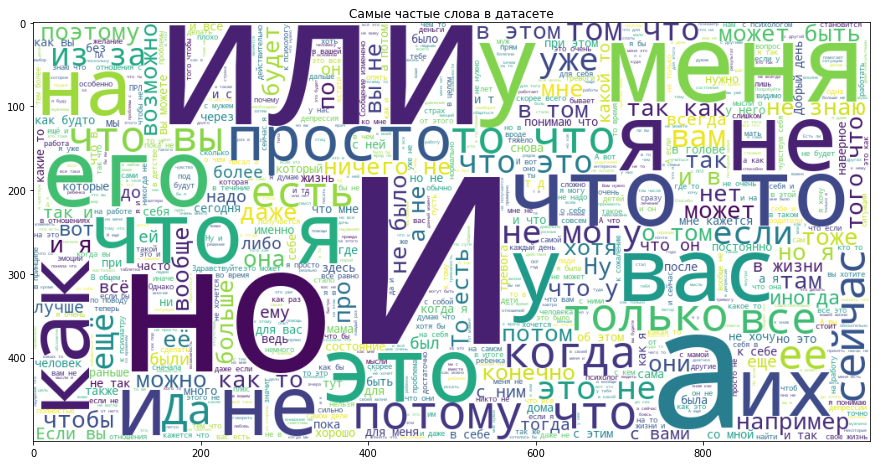

In [25]:
wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=RANDOM_STATE) # создание WordCloud объекта
wordcloud.generate(" ".join(dataset[DATA_COL])) # отправляем в WordCloud весь текст из датасета

plt.figure(figsize=(15,10)) # задание размера фигуры
plt.imshow(wordcloud) # отображение картинки
plt.title("Самые частые слова в датасете") # название фигуры
plt.show() # показ фигуры

## Векторизация (токенизация) данных

In [26]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME) # загружаем предобученный токенизатор
tokenizer

BertTokenizerFast(name_or_path='cointegrated/rubert-tiny-toxicity', vocab_size=29564, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [27]:
vocab_len = len(tokenizer.vocab) # размер словаря
print(f"Размер словаря токенизатора: {vocab_len}.")

Размер словаря токенизатора: 29564.


In [28]:
word2id = {} # словарь соответствия слова его id_шнику
id2word = {} # словарь соответствия id_шника слову
for word, id in tokenizer.vocab.items(): # идём по словам в словаре
    word2id[word] = id # заполняем словарь соответствия слова его id_шнику
    id2word[id] = word # заполняем словарь соответствия id_шника слову

In [29]:
encoded_data = tokenizer(dataset[DATA_COL].tolist(), max_length=MAX_SEQUENCE_LEN, return_tensors="np", truncation=True, padding=True) # токенизируем данные (max_length — максимальное число токенов в документе, return_tensors — тип возвращаемых данных, np для numpy.array, pt для torch.tensor; truncation и padding — обрезание лишних токенов и автозаполнение недостающих до max_length)
print(f"Пример токенизации документа: {encoded_data['input_ids'][0]}.") # пример токенизации первого документа

Пример токенизации документа: [    2  9057   656   745 24436  2841  4045     5   299 17717   281 19195
    22  6511    18  1041 10979  5166   331 16615 14795 18289 10429   329
 25463 17596   548 23378   954    16  1129  3200   769 26662  3707  1046
  2225  5353 23690   721    18 21249   778    17   650  3136  3910  4495
   328 12958  5856   329 18609  2156    12 22636   971 21662 13648 15332
 13041    16 18119   745  6220  1561  2412  6796   887 27247    16  6645
   769 26662  3707    13    16   314 15665  4495 11676 15136   328 12958
  2993    16   769 26662  3707   778    17   650  6645    16 12133 26662
  3707  5943 18235 18268  5406  2161   603   320 15803 20807   331  3389
  1690 28194 20732 14745  7100   700    18   292   644  1845 24586  3910
  6041   314   626  9634   320 29090    18 11939  1373   769 28995  3687
   689 13212 10404  4045    16   548 28148   769   320 23810 24681    18
 24499  7843  1348    35  6226 11677  5548   329 21105  1090    16  5548
  4674    16 15332  8

In [30]:
for token in encoded_data['input_ids'][0][:50]: # идём по токенам примера 0
    print(f"{token} — {id2word[token]}") # выводим токен (id) и соответствующее ему слово

2 — [CLS]
9057 — Все
656 — ##м
745 — до
24436 — ##бр
2841 — ##ый
4045 — день
5 — !
299 — У
17717 — меня
281 — Б
19195 — ##АР
22 — 2
6511 — типа
18 — .
1041 — На
10979 — ##чала
5166 — часто
331 — у
16615 — ##по
14795 — ##тр
18289 — ##еб
10429 — ##лять
329 — с
25463 — ##пир
17596 — ##тные
548 — на
23378 — ##пит
954 — ##ки
16 — ,
1129 — при
3200 — этом
769 — не
26662 — пом
3707 — ##ню
1046 — что
2225 — про
5353 — ##ис
23690 — ##ходил
721 — ##о
18 — .
21249 — Именно
778 — из
17 — -
650 — за
3136 — этого
3910 — несколько
4495 — раз
328 — р
12958 — ##уга


## Train-test Split

In [31]:
# data_X = encoded_data["input_ids"] # запоминаем токены (после данной токенизации они идут в словаре под "input_ids")
# data_X = pd.DataFrame(data_X, columns=[f"Токен {i+1}" for i in range(data_X.shape[1])]) # конвертируем в DataFrame

# print(f"Финальная размерность токенизированных документов: сэмплов — {data_X.shape[0]}, токенов — {data_X.shape[1]}.")
# data_X

Финальная размерность токенизированных документов: сэмплов — 20894, токенов — 330.


,Токен 1,Токен 2,Токен 3,Токен 4,Токен 5,Токен 6,Токен 7,Токен 8,Токен 9,Токен 10,...,Токен 321,Токен 322,Токен 323,Токен 324,Токен 325,Токен 326,Токен 327,Токен 328,Токен 329,Токен 330
0,2,9057,656,745,24436,2841,4045,5,299,17717,...,1499,5709,2987,988,705,9354,29418,3689,5,3
1,2,26629,689,8958,10548,948,35,8388,5144,1044,...,0,0,0,0,0,0,0,0,0,0
2,2,291,15531,2594,4159,3464,1348,332,2259,19578,...,0,0,0,0,0,0,0,0,0,0
3,2,3086,13167,7084,920,2085,866,18,5130,6003,...,8501,650,3277,15333,4550,1241,12824,1736,20816,3
4,2,2389,26629,18754,2480,644,329,281,19195,14050,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20889,2,7081,27538,603,16410,29469,751,16,4674,29231,...,0,0,0,0,0,0,0,0,0,0
20890,2,24595,18092,2698,20247,769,13157,11566,2749,333,...,0,0,0,0,0,0,0,0,0,0
20891,2,313,17049,7525,22541,650,23964,18,297,28890,...,3881,751,4064,9922,1908,18,14556,15531,17022,3
20892,2,314,9720,28527,4307,16,2692,24174,6210,2262,...,2389,1563,6796,10227,4307,2156,18,280,871,3


In [32]:
data_X = pd.DataFrame(columns=encoded_data.keys()) # создаём DataFrame под под данные из токенизатора
for key in encoded_data.keys(): # идём по ключам (input_ids, attention_mask, token_type_ids)
    data_X[key] = encoded_data[key].tolist() # добавляем данные

print(f"Финальная размерность токенизированных документов: сэмплов — {data_X['input_ids'].shape[0]}, токенов — {len(data_X['input_ids'][0])}.")
data_X

Финальная размерность токенизированных документов: сэмплов — 20894, токенов — 330.


,input_ids,token_type_ids,attention_mask
0,"[2, 9057, 656, 745, 24436, 2841, 4045, 5, 299,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[2, 26629, 689, 8958, 10548, 948, 35, 8388, 51...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[2, 291, 15531, 2594, 4159, 3464, 1348, 332, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[2, 3086, 13167, 7084, 920, 2085, 866, 18, 513...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[2, 2389, 26629, 18754, 2480, 644, 329, 281, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
20889,"[2, 7081, 27538, 603, 16410, 29469, 751, 16, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
20890,"[2, 24595, 18092, 2698, 20247, 769, 13157, 115...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
20891,"[2, 313, 17049, 7525, 22541, 650, 23964, 18, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
20892,"[2, 314, 9720, 28527, 4307, 16, 2692, 24174, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [33]:
data_y = pd.get_dummies(dataset[TARGET_COL], dtype=DTYPE) # делаем One-hot encoding для таргетов
labels = data_y.columns # уникальные значения таргетов (колонки One-hot encodding таргетов)

print(f"Размерность таргетов: сэмплов — {data_y.shape[0]}, таргетов — {data_y.shape[1]}.")
data_y

Размерность таргетов: сэмплов — 20894, таргетов — 6.


,БАР,ДЕПРЕССИЯ,ОКР,ПРЛ,ТРЕВОЖНОЕ Р-ВО,ШИЗОФРЕНИЯ
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
20889,0.0,0.0,0.0,0.0,0.0,1.0
20890,0.0,0.0,0.0,0.0,0.0,1.0
20891,0.0,0.0,0.0,0.0,0.0,1.0
20892,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_y, shuffle=True)
# разбиваем датасет (data_X — данные, data_y — One-hot encoded таргеты) на обучающую и тестовую выборки в соотношении TEST_SIZE, при этом пропорция таргетов должна быть одинаковой (stratify=data_y) в обоих выборках и данные должны быть перемешаны (shuffle=True)

c:\Users\User\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\User\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\User\anaconda3\envs\gpu\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Resampling

In [32]:
# if SAMPLES_PER_CLASS: # если число сэплов за класс задано
#     max_samples = SAMPLES_PER_CLASS # используем его как параметр для resample
# else: # иначе — выравниваем по самому представленному классу
#     max_samples = y_train.value_counts()[0] # число элементов в наиболее представленном классе

# # сначала получаем данные о распределении фич для каждого класса, чтобы потом провести их выравнивание (resampling)
# y_values = y_train.idxmax(axis=1) # обратно преобразовываем One-hot таргеты в один столбец (только для поиска распределения данных X)
# data_resampled = pd.DataFrame(columns=[X_train.columns].extend(labels)) # заготовка под DataFrame без дисбаланса классов (слолбцы — всё, что есть в data_X и data_y)
# for target_value in labels: # идём по уникальным таргетам
#     data_distribution = X_train[y_values == target_value] # записываем в data_distribution TF-IDF вектора, соответствующие рассматриваемому target_value
#     print(f"    В классе '{target_value}' было {len(data_distribution)} записей.")

#     data_distribution = resample(data_distribution, n_samples=max_samples, random_state=RANDOM_STATE) # добавляем (удаляем) записи к рассматриваемому таргету до n_samples по соответствующему распределению
#     print(f"    В классе '{target_value}' стало {len(data_distribution)} записей.")

#     data_for_label = pd.DataFrame(data_distribution) # создаём DataFrame из векторов, соответствующих рассматриваемому таргету
#     data_for_label[labels] = pd.DataFrame([y_train[y_values == target_value].iloc[0]], index=data_for_label.index) # добавляем колонки One-hot таргета в DataFrame (index=data_for_label.index — у всех строк будет значение рассматриваемого таргета) (.iloc[0] — берём первое значение One-hot вектора таргета, что совпало по инексу с его не One-hot версией)
#     data_resampled = pd.concat([data_resampled, data_for_label], ignore_index=True) # соединяем вместе все DataFrame_ы классов

# data_resampled = data_resampled.sample(frac=1) # случайным образом перемешиваем датасет

# y_train = data_resampled[labels] # запоминаем таргеты (One-hot)
# data_resampled.drop(labels, axis=1, inplace=True) # в data_resampled (DataFrame) оставляем только вектора фич
# X_train = data_resampled # возвращаем фичи к типу array (хоть можно было оставить и DataFrame)


# # очищаем память из под вспомогательных объектов
# del data_distribution
# del data_for_label
# del data_resampled
# print(f"Размерность после обработки: сэмплов — {X_train.shape[0]}, фич — {X_train.shape[1]}, таргетов — {y_train.shape[1]}.")

    В классе 'БАР' было 886 записей.
    В классе 'БАР' стало 5000 записей.
    В классе 'ДЕПРЕССИЯ' было 11699 записей.
    В классе 'ДЕПРЕССИЯ' стало 5000 записей.
    В классе 'ОКР' было 1884 записей.
    В классе 'ОКР' стало 5000 записей.
    В классе 'ПРЛ' было 1807 записей.
    В классе 'ПРЛ' стало 5000 записей.
    В классе 'ТРЕВОЖНОЕ Р-ВО' было 4568 записей.
    В классе 'ТРЕВОЖНОЕ Р-ВО' стало 5000 записей.
    В классе 'ШИЗОФРЕНИЯ' было 600 записей.
    В классе 'ШИЗОФРЕНИЯ' стало 5000 записей.
Размерность после обработки: сэмплов — 30000, фич — 3, таргетов — 6.


Получившиеся матрицы.

In [6]:
X_train

,input_ids,token_type_ids,attention_mask
13424,"[2, 18624, 331, 17717, 3915, 12046, 314, 866, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
13278,"[2, 3130, 24436, 2841, 4045, 16, 20305, 18, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
15983,"[2, 284, 26965, 1072, 948, 1556, 548, 4404, 76...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2286,"[2, 296, 24404, 3277, 3076, 16, 314, 1556, 112...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
17452,"[2, 2300, 28, 12236, 12, 2389, 28, 2262, 11963...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
18826,"[2, 9672, 16, 26629, 20284, 2389, 9252, 19167,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4095,"[2, 297, 4623, 22804, 25698, 13778, 2215, 1097...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1231,"[2, 2184, 20829, 2085, 656, 325, 644, 7322, 24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
18951,"[2, 10841, 4225, 17, 1619, 18801, 5856, 745, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [7]:
y_train

,БАР,ДЕПРЕССИЯ,ОКР,ПРЛ,ТРЕВОЖНОЕ Р-ВО,ШИЗОФРЕНИЯ
13424,0.0,0.0,1.0,0.0,0.0,0.0
13278,0.0,0.0,1.0,0.0,0.0,0.0
15983,0.0,0.0,0.0,0.0,1.0,0.0
2286,0.0,1.0,0.0,0.0,0.0,0.0
17452,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
18826,0.0,0.0,0.0,0.0,1.0,0.0
4095,0.0,1.0,0.0,0.0,0.0,0.0
1231,0.0,1.0,0.0,0.0,0.0,0.0
18951,0.0,0.0,0.0,0.0,1.0,0.0


Распределение таргетов после resample.

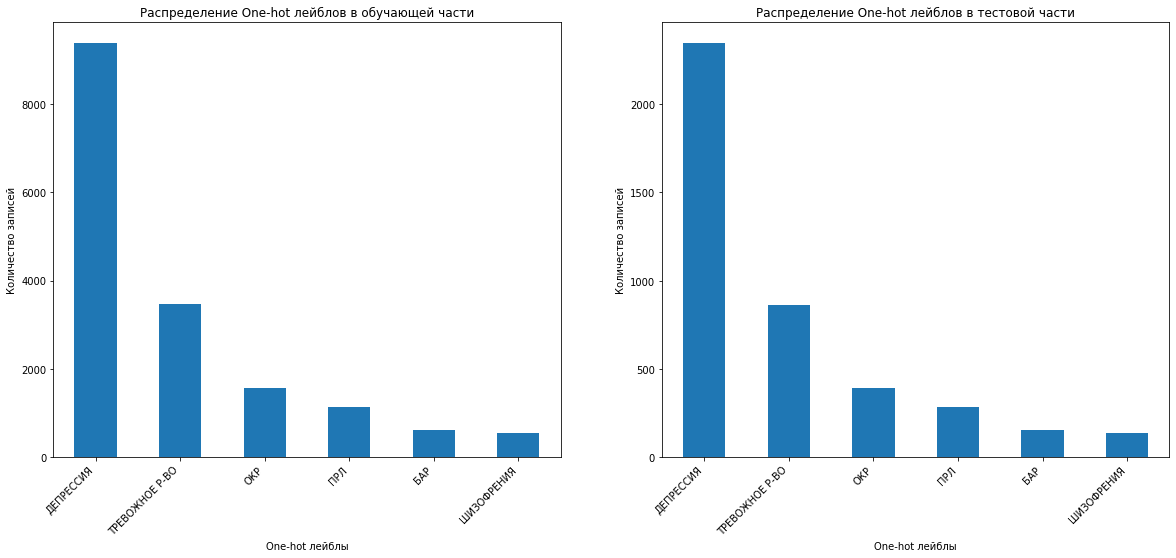

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

y_train.idxmax(axis=1).value_counts().plot.bar(ax=axes[0]) # построение столбчатой диаграммы по данным на оси ax (idxmax — чтобы преобразовать One-hot encoded данные обратно в таргеты)
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[0].set_title("Распределение One-hot лейблов в обучающей части") # название фигуры
axes[0].set_xlabel("One-hot лейблы") # подпись по оси OX
axes[0].set_ylabel("Количество записей") # подпись по оси OY

y_test.idxmax(axis=1).value_counts().plot.bar(ax=axes[1]) # построение столбчатой диаграммы по данным на оси ax (idxmax — чтобы преобразовать One-hot encoded данные обратно в таргеты)
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[1].set_title("Распределение One-hot лейблов в тестовой части") # название фигуры
axes[1].set_xlabel("One-hot лейблы") # подпись по оси OX
axes[1].set_ylabel("Количество записей") # подпись по оси OY

plt.show() # показ фигуры

In [36]:
# X_train.to_pickle(f"{DATA_DIR}X_train.pkl")
# X_test.to_pickle(f"{DATA_DIR}X_test.pkl")
# y_train.to_pickle(f"{DATA_DIR}y_train.pkl")
# y_test.to_pickle(f"{DATA_DIR}y_test.pkl")

In [5]:
# X_train = pd.read_pickle(f"{DATA_DIR}X_train.pkl")
# X_test = pd.read_pickle(f"{DATA_DIR}X_test.pkl")
# y_train = pd.read_pickle(f"{DATA_DIR}y_train.pkl")
# y_test = pd.read_pickle(f"{DATA_DIR}y_test.pkl")
# labels = y_test.columns # уникальные значения таргетов (колонки One-hot encodding таргетов)

# Работа с моделью

## Выбор подходящей модели

Лучшая — та, что правильнее выдаёт ответы на задаче Zero-shot classification, так как у неё лучше всех подходят веса к рассматриваемой задаче.

In [ ]:
# from transformers import pipeline # для инференса модели

# TASK = "zero-shot-classification" # название задачи для pipeline
# classifier = pipeline(task=TASK, model=MODEL_NAME, device=DEVICE) # создаём pipeline для задачи task с использованием модели model с запуском на девайсе device
# classifier(dataset.loc[0][DATA_COL], candidate_labels=labels) # запуск инференса

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'sequence': 'всем добрый день ! бар 2 типа . начала часто употреблять спиртные напитки , помню происходило . именно из-за несколько ругалась мужем ( творила всякую дичь , вплоть звонков бывшему , помню ) , последний сильно начали ругаться , помню из-за , помню лишь чувство страха бывший появляется двери нашей квартиры . муж взял несколько своих вещей ушёл . домой возвращается седьмой день , контакт идет вообще . делать ? могу спать , , дикие истерики первые 4 дня вплоть самоповреждения . полегче , истерики продолжаются ( 1 1-2 дня , ближе ночи ) . очень хочу всё исправить , вернуть любимого , неизвестность тревожит , понимаю , очень накосячила , переосмыслила жизнь , отношения , нашла миллион косяков своей стороны , готова всё исправить , начинаю работать собой , ищу хорошего психиатра ( прошлый психиатр упорно назначал антидепрессанты , которых становилось хуже ) . помогите пожалуйста ! чувствую разбитой , неполноценной , больной . испытываю огромное чувство вины стыда . заранее спас

## Загрузка модели

In [37]:
# input_size = X_train.shape[1] # размер входного вектора (для одного сэмпла, в данном случае совпадает с MAX_SEQUENCE_LEN)
input_size = len(X_train["input_ids"].iloc[0]) # размер входного вектора (для одного сэмпла, в данном случае совпадает с MAX_SEQUENCE_LEN)
target_size = y_train.shape[1] # размер выходного вектора (число таргетов)

Создаём свою модель или загружаем предобученную.

In [13]:
# class Classification_model(nn.Module):
#     def __init__(self): # конструктор модели
#         super().__init__() # для инициализации базового класса (nn.Module)

#         # self.base_model = AutoModel.from_pretrained(MODEL_NAME) # загружаем модель с весами
#         config = AutoConfig.from_pretrained(MODEL_NAME) # настройки модели
#         config.vocab_size = vocab_len # меняем под число токенов в токенизаторе (многоязыковой)
#         self.base_model = AutoModel.from_config(config) # загружаем модель по конфигурации (без весов)

#         self.linear_1 = nn.Linear(in_features=self.base_model.config.hidden_size, out_features=1024, bias=True) # полносвязный линейный слой, на вход (batch_size, in_features), выход - (batch_size, out_features)
#         self.dropout = nn.Dropout(p=0.1) # dropout для предотвращения переобучения
#         self.linear_2 = nn.Linear(in_features=1024, out_features=target_size, bias=True) # полносвязный линейный слой, на вход (batch_size, in_features), выход - (batch_size, out_features)
#         self.softmax = nn.Softmax(dim=1) # softmax для конвертации в вероятности классов

#     def forward(self, input_ids, attention_mask): # forward-метод модели
#         y = self.base_model(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] # вызываем базовую модель (Bert)
#         y = self.linear_1(y) # вызываем линейный слой
#         y = self.dropout(y) # вызываем dropout
#         y = self.linear_2(y) # вызываем линейный слой
#         y = self.softmax(y) # вызываем softmax
#         return y

In [38]:
# model = Classification_model() # создаём модель

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME) # загружаем модель для классификации текста
model.classifier = nn.Linear(in_features=312, out_features=target_size, bias=True) # меняем голову модели (у неё по стандарту requires_grad=True)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

Включаем/отключаем параметры (веса) при обучении.

In [ ]:
for p in model.parameters(): # идём по параметрам модели
    p.requires_grad = True # отключаем их обучение

In [39]:
print(f"Число обучаемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad)}.") # считаем число параметров

Число обучаемых параметров: 11786046.


Собираем Torch датасет.

In [40]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, device):
        self.device = device
        self.input_ids = torch.stack([torch.tensor(seq, dtype=torch.int32) for seq in X["input_ids"]]) # создаём torch.tensor типа dtype из списка списков
        self.attention_mask = torch.stack([torch.tensor(seq, dtype=torch.int32) for seq in X["attention_mask"]]) # создаём torch.tensor типа dtype из списка списков
        self.labels = torch.tensor(Y.values, dtype=torch.float32) # конвертируем np.array в torch.tensor типа dtype

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx].to(self.device),
            'attention_mask': self.attention_mask[idx].to(self.device),
            'label': self.labels[idx].to(self.device)
        }


def collate_batch(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'label': torch.stack([item['label'] for item in batch])
    }

Отправляем всё на используемый девайс.

In [41]:
model.to(DEVICE) # отправляем модель на девайс

dataset_train = CustomDataset(X_train, y_train, DEVICE) # создаём обучающий датасет
dataset_test = CustomDataset(X_test, y_test, DEVICE) # создаём тестовый датасет

loader_train = DataLoader(dataset=dataset_train, 
                          batch_size=BATCH_SIZE, # размер батча (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла и ухудшается качество обучения)
                          collate_fn=collate_batch, # функция для генерации батчей по dataset
                          shuffle=True, # перемешивать ли датасет
                        #   num_workers=2, # число используемых ядер процессора для ускорения обработки данных
                        #   pin_memory=True # нужно ли заранее аллоцировать память под объект на GPU (лучше так, чем возвращать CUDA tensors при multi-process loading)
                         )
loader_test = DataLoader(dataset=dataset_test, # указание датасета для DataLoader
                         batch_size=BATCH_SIZE, # размер батча (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла и ухудшается качество обучения)
                         collate_fn=collate_batch, # функция для генерации батчей по dataset
                         shuffle=False, # перемешивать ли датасет
                        #  num_workers=2, # число используемых ядер процессора для ускорения обработки данных
                        #  pin_memory=True # нужно ли заранее аллоцировать память под объект на GPU (лучше так, чем возвращать CUDA tensors при multi-process loading)
                        )

Функция потерь.

In [42]:
loss_func = nn.CrossEntropyLoss(reduction="mean") # функция потерь (кросс-энтропия)
# CrossEntropyLoss в torch сильно отличается от аналогичной в tensorflow, тут даже если все ответы совпали, loss не будет равен нулю из-за того что он считается по формуле 'torch.nn.functional.nll_loss(torch.nn.functional.log_softmax(Input, 1), label)'

# loss_func = nn.MSELoss(reduction="mean") # функция потерь (квадрат разности)

Оптимизатор обучения модели.

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # оптимизатор для обучения параметров модели с шагом обучения lr

Обучение.

In [44]:
def train(model, loader, loss_func, optimizer) -> tuple:
    """
    Функция для обучения модели на одной эпохе.\n
    Parameters:
        * model: обучаемая модель
        * loader: DataLoader, предоставляющий данные для обучения модели
        * loss_func: функция потерь
        * optimizer: оптимизатор обучения\n
    Returns:
        * tuple: значения (loss, F-score, accuracy) за эпоху обучения
    """
    model.train() # перевод модели в режим обучения (dropout работает, а BatchNorm собирает статистику)
    total_loss = 0.0 # общий loss за эпоху обучения 
    y_preds = [] # список под предсказанные лейблы
    y_trues = [] # список под правильные лейблы
    
    for batch in tqdm(loader): # идём по батчам loader_а
        input_ids, attention_mask, y_true = batch['input_ids'], batch['attention_mask'], batch['label'] # берём данные батча
        optimizer.zero_grad() # обнуляем градиенты во всех обучаемых torch.Tensor (ставит w.grad = 0 в torch.Tensor с requires_grad=True) (вызывается перед loss.backward(), чтобы не аккумулировать градиенты за несколько итераций обучения)
        # y_pred = model(input_ids, attention_mask) # вызываем forward pass модели (y_pred - вероятности, если выход модели был Softmax)
        y_pred = model(input_ids, attention_mask).logits # вызываем forward pass модели (y_pred - некие числа, пока не вероятности - logits)

        # loss = loss_func(y_pred, y_true) # считаем значение loss функции
        loss = loss_func(y_pred, y_true.argmax(dim=1)) # считаем значение loss функции (если CrossentropyLoss, то y_true в PyTorch должен быть не вероятностями, а уже предсказываемыми классами, хотя с вероятностями оно будет работать немного иначе)

        loss.backward() # считаем dloss/dw для каждого веса модели w, у которого requires_grad=True (сохраняется в w.grad следующим образом w.grad += dloss/dw)
        optimizer.step() # обновляет веса модели (тензоры, у которых стоит флаг requires_grad=True, используя значение из w.grad следующим образом w += -lr * w.grad)
        
        # запоминаем предсказания
        y_preds.append(nn.Softmax(dim=1)(y_pred)) # запоминаем предсказания (Softmax - переходим к вероятностям классов)
        # y_preds.append(y_pred) # запоминаем предсказания
        y_trues.append(y_true) # запоминаем ожидаемые предсказания

        total_loss += loss.item() # добавляем значение loss за батч к общему loss
    avg_loss = total_loss / len(loader) # усредняем loss по числу батчей

    # считаем дополнительные метрики
    y_preds = torch.cat(y_preds) # объединяем список тензоров в один тензор
    y_trues = torch.cat(y_trues) # объединяем список тензоров в один тензор
    labels_pred = y_preds.argmax(dim=1) # самый вероятный класс в предсказании
    labels_true = y_trues.argmax(dim=1) # самый вероятный ожидаемый класс

    f_score = multiclass_f1_score(labels_pred, labels_true, num_classes=y_trues.shape[1], average="macro").item() # считаем F-score 
    accuracy = (labels_pred == labels_true).sum().item() / labels_true.shape[0] # считаем accuracy (число правильных предсказаний, делённое на общее число предсказаний)

    return avg_loss, f_score, accuracy

In [45]:
def test(model, loader, loss_func) -> tuple:
    """
    Функция для тестирования модели на одной эпохе.\n
    Parameters:
        * model: обучаемая модель
        * loader: DataLoader, предоставляющий данные для теста модели
        * loss_func: функция потерь\n
    Returns:
        * tuple: значения (loss, F-score, accuracy) за эпоху тестирования
    """
    model.eval() # перевод модель в режим оценивания (dropout перестаёт работать, а BatchNorm собирать статистику)
    total_loss = 0.0 # общий loss за эпоху обучения
    y_preds = [] # список под предсказанные лейблы
    y_trues = [] # список под правильные лейблы
    
    with torch.no_grad(): # отключаем подсчёт градиентов
        for batch in tqdm(loader): # идём по батчам loader_а
            input_ids, attention_mask, y_true = batch['input_ids'], batch['attention_mask'], batch['label'] # берём данные батча
            # y_pred = model(input_ids, attention_mask) # вызываем forward pass модели (y_pred - вероятности, если выход модели был Softmax)
            y_pred = model(input_ids, attention_mask).logits # вызываем forward pass модели (y_pred - некие числа, пока не вероятности - logits)

            # loss = loss_func(y_pred, y_true) # считаем значение loss функции
            loss = loss_func(y_pred, y_true.argmax(dim=1)) # считаем значение loss функции (если CrossentropyLoss, то y_true в PyTorch должен быть не вероятностями, а уже предсказываемыми классами, хотя с вероятностями оно будет работать немного иначе)

            # запоминаем предсказания
            y_preds.append(nn.Softmax(dim=1)(y_pred)) # запоминаем предсказания (Softmax - переходим к вероятностям классов)
            # y_preds.append(y_pred) # запоминаем предсказания (Softmax - переходим к вероятностям классов)
            y_trues.append(y_true) # запоминаем ожидаемые предсказания

            total_loss += loss.item() # добавляем значение loss за батч к общему loss
    avg_loss = total_loss / len(loader) # усредняем loss по числу батчей

    # считаем дополнительные метрики
    y_preds = torch.cat(y_preds) # объединяем список тензоров в один тензор
    y_trues = torch.cat(y_trues) # объединяем список тензоров в один тензор
    labels_pred = y_preds.argmax(dim=1) # самый вероятный класс в предсказании
    labels_true = y_trues.argmax(dim=1) # самый вероятный ожидаемый класс

    f_score = multiclass_f1_score(labels_pred, labels_true, num_classes=y_trues.shape[1], average="macro").item() # считаем F-score 
    accuracy = (labels_pred == labels_true).sum().item() / labels_true.shape[0] # считаем accuracy (число правильных предсказаний, делённое на общее число предсказаний)

    return avg_loss, f_score, accuracy

In [46]:
history = {"loss": [], "f_score": [], "accuracy": [], "val_loss": [], "val_f_score": [], "val_accuracy": []} # словарь под историю обучения

In [47]:
max_f_score = 0 # максимальный F-score
iters_without_improve = 0 # число итераций без улучшения отслеживаемой метрики (F-score)

time_start = time.time() # замеряем время начала обучения
for epoch in range(EPOCHS): # идём по числу эпох
    train_loss, train_f_score, train_accuracy = train(model, loader_train, loss_func, optimizer) # обучение модели
    test_loss, test_f_score, test_accuracy = test(model, loader_test, loss_func) # тестирование модели
    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Train F-score: {train_f_score:.2f}, Train Accuracy: {train_accuracy:.2%}, Test Loss: {test_loss:.4f}, Test F-score: {test_f_score:.2f}, Test Accuracy: {test_accuracy:.2%}")

    if test_f_score > max_f_score: # если модель улучшила F-score
        torch.save(model.state_dict(), f"{MODELS_DIR}best_model.pt") # сохраняем веса модели
        max_f_score = test_f_score # обновляем лучший F-score
        iters_without_improve = 0 # обнуляем счётчик итераций без улучшения
    else:
        iters_without_improve += 1 # увеличиваем счётчик итераций без улучшения

    # запоминаем значения метрик
    history["loss"].append(train_loss)
    history["f_score"].append(train_f_score)
    history["accuracy"].append(train_accuracy)
    history["val_loss"].append(test_loss)
    history["val_f_score"].append(test_f_score)
    history["val_accuracy"].append(test_accuracy)

    with open(f'{DATA_DIR}history.pkl', 'wb') as f: # открываем файл для записи по битам (wb)
        pickle.dump(history, f) # сохраняем объект в файл f

    if iters_without_improve > EPOCHS_PATIENCE: # если превышен лимит эпох без улучшения результатов
        break # выходим из цикла обучения
    
print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд.")

  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1/50: Train Loss: 0.9416, Train F-score: 0.46, Train Accuracy: 68.49%, Test Loss: 0.7295, Test F-score: 0.61, Test Accuracy: 75.93%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 2/50: Train Loss: 0.6044, Train F-score: 0.68, Train Accuracy: 79.68%, Test Loss: 0.6372, Test F-score: 0.66, Test Accuracy: 78.92%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 3/50: Train Loss: 0.4646, Train F-score: 0.76, Train Accuracy: 84.31%, Test Loss: 0.6839, Test F-score: 0.66, Test Accuracy: 76.50%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 4/50: Train Loss: 0.3520, Train F-score: 0.82, Train Accuracy: 88.29%, Test Loss: 0.6839, Test F-score: 0.67, Test Accuracy: 78.77%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 5/50: Train Loss: 0.2468, Train F-score: 0.88, Train Accuracy: 91.91%, Test Loss: 0.7877, Test F-score: 0.66, Test Accuracy: 77.58%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 6/50: Train Loss: 0.1749, Train F-score: 0.92, Train Accuracy: 94.22%, Test Loss: 0.8800, Test F-score: 0.65, Test Accuracy: 77.53%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 7/50: Train Loss: 0.1253, Train F-score: 0.94, Train Accuracy: 95.99%, Test Loss: 0.9540, Test F-score: 0.65, Test Accuracy: 76.19%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 8/50: Train Loss: 0.0963, Train F-score: 0.95, Train Accuracy: 96.85%, Test Loss: 1.0654, Test F-score: 0.66, Test Accuracy: 75.76%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 9/50: Train Loss: 0.0700, Train F-score: 0.97, Train Accuracy: 97.81%, Test Loss: 1.0577, Test F-score: 0.66, Test Accuracy: 77.22%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 10/50: Train Loss: 0.0606, Train F-score: 0.97, Train Accuracy: 97.93%, Test Loss: 1.1033, Test F-score: 0.65, Test Accuracy: 76.93%
Время, затраченное на обучение: 2095.715472459793 секунд.


# Оценка качества модели

Загрузка лучшей модели.

In [48]:
# model = Classification_model()
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME) # загружаем модель для классификации текста
model.classifier = nn.Linear(in_features=312, out_features=target_size, bias=True) # меняем голову модели (у неё по стандарту requires_grad=True)

model.load_state_dict(torch.load(f"{MODELS_DIR}best_model.pt", map_location=DEVICE)) # загружаем сохранённые веса модели (map_location - на соответствующий девайс)
model.to(DEVICE) # отправляем модель на девайс

with open(f'{DATA_DIR}history.pkl', 'rb') as f: # открываем файл для чтения по битам (wb)
    history = pickle.load(f) # загружаем объект из файла

## Loss & Accuracy & F-score

In [50]:
print(history.keys()) # ключи в словаре истории

dict_keys(['loss', 'f_score', 'accuracy', 'val_loss', 'val_f_score', 'val_accuracy'])


In [53]:
epochs = range(1, len(history["loss"]) + 1) # число эпох обучения (сколько было сохранено значений loss)
loss_train = history["loss"] # значение loss при обучении
loss_test = history["val_loss"] # значение loss при валидации
accuracy_train = history["accuracy"] # значение accuracy при обучении
accuracy_test = history["val_accuracy"] # значение accuracy при валидации
f_score_train = history["f_score"] # значение F-score при обучении
f_score_test = history["val_f_score"] # значение F-score при обучении

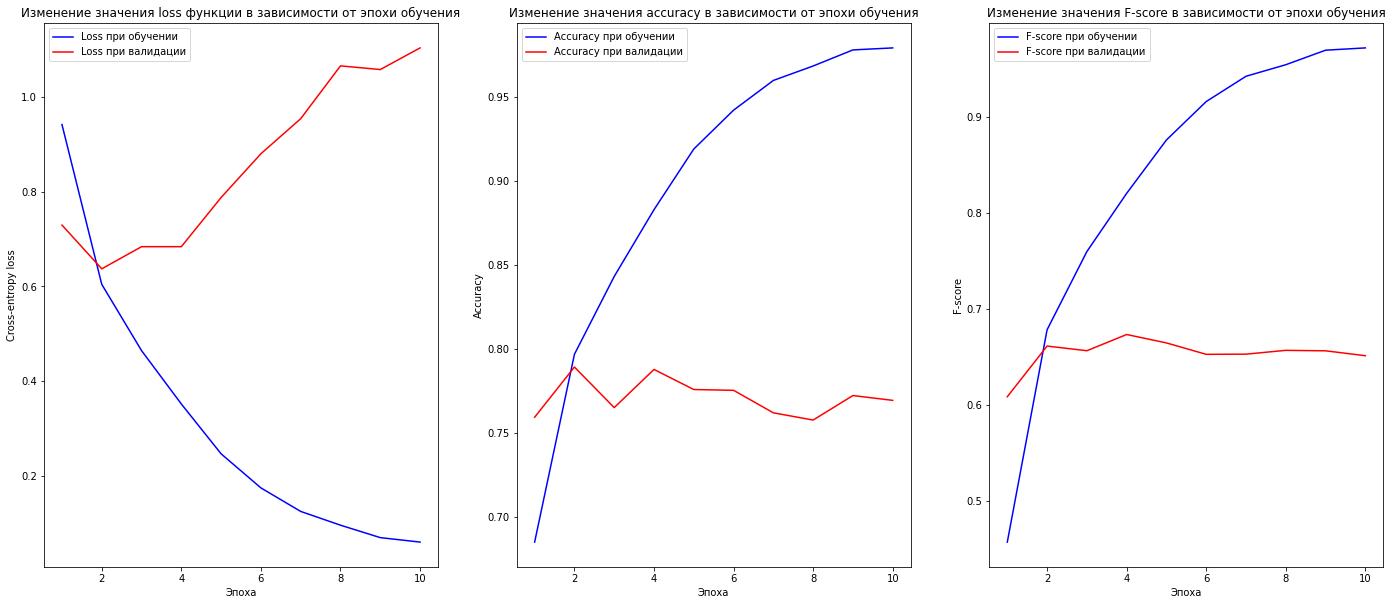

In [58]:
fig, axes = plt.subplots(ncols=3, figsize=(24,10)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

axes[0].plot(epochs, loss_train, color="b", label="Loss при обучении") # построение графика
axes[0].plot(epochs, loss_test, color="r", label="Loss при валидации") # построение графика
# axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[0].set_title("Изменение значения loss функции в зависимости от эпохи обучения") # название фигуры
axes[0].set_xlabel("Эпоха") # подпись по оси OX
axes[0].set_ylabel("Cross-entropy loss") # подпись по оси OY
axes[0].legend() # отображение подписей графиков

axes[1].plot(epochs, accuracy_train, color="b", label="Accuracy при обучении") # построение графика
axes[1].plot(epochs, accuracy_test, color="r", label="Accuracy при валидации") # построение графика
# axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[1].set_title("Изменение значения accuracy в зависимости от эпохи обучения") # название фигуры
axes[1].set_xlabel("Эпоха") # подпись по оси OX
axes[1].set_ylabel("Accuracy") # подпись по оси OY
axes[1].legend() # отображение подписей графиков

axes[2].plot(epochs, f_score_train, color="b", label="F-score при обучении") # построение графика
axes[2].plot(epochs, f_score_test, color="r", label="F-score при валидации") # построение графика
# axes[2].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[2].set_title("Изменение значения F-score в зависимости от эпохи обучения") # название фигуры
axes[2].set_xlabel("Эпоха") # подпись по оси OX
axes[2].set_ylabel("F-score") # подпись по оси OY
axes[2].legend() # отображение подписей графиков

plt.show() # показ фигуры

## F-score

In [ ]:
y_preds = [] # список под предсказанные лейблы
y_trues = [] # список под правильные лейблы

model.eval() # перевод модель в режим оценивания (dropout перестаёт работать, а BatchNorm собирать статистику)
with torch.no_grad(): # отключаем подсчёт градиентов
    for batch in tqdm(loader_test): # идём по батчам loader_а
        input_ids, attention_mask, y_true = batch['input_ids'], batch['attention_mask'], batch['label'] # берём данные батча
        # y_pred = model(input_ids, attention_mask) # вызываем forward pass модели (y_pred - вероятности, если выход модели был Softmax)
        y_pred = model(input_ids, attention_mask).logits # вызываем forward pass модели (y_pred - некие числа, пока не вероятности - logits)

        y_preds.append(nn.Softmax(dim=1)(y_pred)) # запоминаем предсказания (Softmax - переходим к вероятностям классов)
        # y_preds.append(y_pred) # запоминаем предсказания (Softmax - переходим к вероятностям классов)
        y_trues.append(y_true) # запоминаем ожидаемые предсказания

# считаем дополнительные метрики
y_preds = torch.cat(y_preds) # объединяем список тензоров в один тензор
y_trues = torch.cat(y_trues) # объединяем список тензоров в один тензор
y_pred = y_preds.argmax(dim=1).cpu() # самый вероятный класс в предсказании (.cpu() — возвращаем с девайса на CPU)
y_true = y_trues.argmax(dim=1).cpu() # самый вероятный ожидаемый класс (.cpu() — возвращаем с девайса на CPU)

In [66]:
print(classification_report(y_true, y_pred, zero_division=0, target_names=labels)) # выводим основные метрики, такие как precision, recall, f1-score, accuracy (zero_division=0 — деление на ноль заменять нулём)

                precision    recall  f1-score   support

           БАР       0.60      0.41      0.49       154
     ДЕПРЕССИЯ       0.83      0.89      0.86      2345
           ОКР       0.74      0.54      0.63       394
           ПРЛ       0.78      0.73      0.75       286
ТРЕВОЖНОЕ Р-ВО       0.72      0.75      0.73       865
    ШИЗОФРЕНИЯ       0.65      0.53      0.58       135

      accuracy                           0.79      4179
     macro avg       0.72      0.64      0.67      4179
  weighted avg       0.78      0.79      0.78      4179



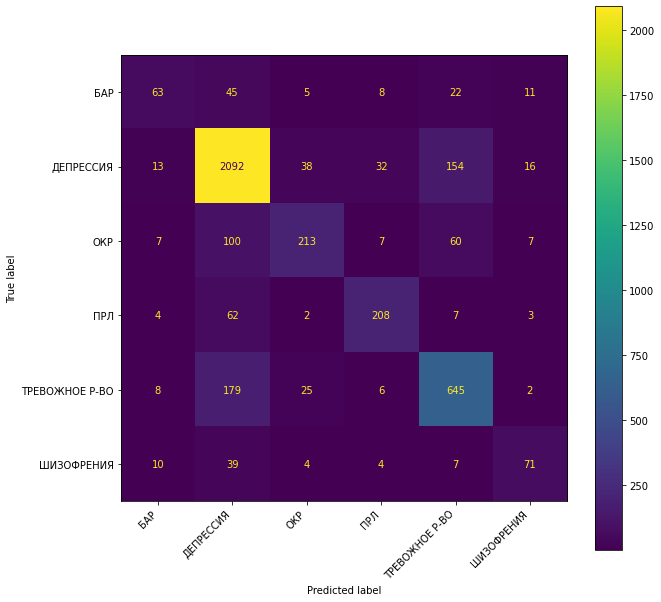

In [67]:
fig, ax = plt.subplots(figsize=(10,10)) # создание фигуры
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels).plot(ax=ax) # строим confusion matrix (стоит обратить внимание на display_labels, они могут не совпасть...)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
plt.show() # показ фигуры

# Тестирование моделей

In [ ]:
# d_t = CustomDataset(X_train[:1], y_train[:1], DEVICE) # создаём обучающий датасет
d_t = CustomDataset(X_train[:100], y_train[:100], DEVICE) # создаём обучающий датасет
l_t = DataLoader(dataset=d_t, 
                          batch_size=BATCH_SIZE, # размер батча (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла и ухудшается качество обучения)
                          collate_fn=collate_batch, # функция для генерации батчей по dataset
                          shuffle=True, # перемешивать ли датасет
                         )

In [ ]:
pred = model(torch.tensor(X_train[:1]["input_ids"].values[0], device=DEVICE).reshape(1,MAX_SEQUENCE_LEN), torch.tensor(X_train[:1]["attention_mask"].values[0], device=DEVICE).reshape(1,MAX_SEQUENCE_LEN))
# pred
pred.logits

tensor([[-0.5680,  0.6144, -0.1232, -0.4785,  0.3814,  0.1128]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# pred = model(torch.tensor(X_train[:1]["input_ids"].values[0], device=DEVICE).reshape(1,MAX_SEQUENCE_LEN), torch.tensor(X_train[:1]["attention_mask"].values[0], device=DEVICE).reshape(1,MAX_SEQUENCE_LEN))
# pred
# pred.logits

tensor([[0.0090, 0.0074, 0.0085, 0.0104, 0.9540, 0.0106]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
y_train[:1].values

array([[0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
model.classifier.weight

Parameter containing:
tensor([[ 0.0298, -0.0020, -0.0286,  ...,  0.0184, -0.0359, -0.0071],
        [-0.0172, -0.0070, -0.0039,  ...,  0.0049,  0.0345,  0.0316],
        [-0.0178, -0.0321,  0.0158,  ..., -0.0241,  0.0120,  0.0306],
        [-0.0174, -0.0352,  0.0148,  ...,  0.0167,  0.0269, -0.0193],
        [-0.0290,  0.0333, -0.0243,  ...,  0.0204, -0.0235, -0.0275],
        [-0.0169,  0.0319,  0.0323,  ..., -0.0034,  0.0243,  0.0005]],
       device='cuda:0', requires_grad=True)

In [ ]:
for i in range(50):
    train_loss, train_f_score, train_accuracy = train(model, l_t, loss_func, optimizer) # обучение модели
    test_loss, test_f_score, test_accuracy = test(model, l_t, loss_func) # тестирование модели
    print(f"Epoch {i+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Train F-score: {train_f_score:.2f}, Train Accuracy: {train_accuracy:.2%}, Test Loss: {test_loss:.4f}, Test F-score: {test_f_score:.2f}, Test Accuracy: {test_accuracy:.2%}")

In [ ]:
y_preds = [] # список под предсказанные лейблы
y_trues = [] # список под правильные лейблы

model.eval()
for i in range(10):
    # y_pred = model(dataset_test.__getitem__(i)["input_ids"].reshape(1, MAX_SEQUENCE_LEN), dataset_test.__getitem__(i)["attention_mask"].reshape(1, MAX_SEQUENCE_LEN))
    y_pred = model(dataset_test.__getitem__(i)["input_ids"].reshape(1, MAX_SEQUENCE_LEN), dataset_test.__getitem__(i)["attention_mask"].reshape(1, MAX_SEQUENCE_LEN)).logits
    y_true = dataset_test.__getitem__(i)["label"].reshape(1, 6)
    print(y_pred)
    # y_preds.append(y_pred) # запоминаем предсказания
    y_preds.append(nn.Softmax(dim=1)(y_pred)) # запоминаем предсказания (Softmax - переходим к вероятностям классов)
    y_trues.append(y_true) # запоминаем ожидаемые предсказания
y_preds = torch.cat(y_preds) # объединяем список тензоров в один тензор
y_trues = torch.cat(y_trues) # объединяем список тензоров в один тензор
labels_pred = y_preds.argmax(dim=1) # самый вероятный класс в предсказании
labels_true = y_trues.argmax(dim=1) # самый вероятный ожидаемый класс

print(f"F-score: {multiclass_f1_score(labels_pred, labels_true, num_classes=y_trues.shape[1], average='macro').item()}")
print(f"Accuracy: {(labels_pred == labels_true).sum() / labels_true.shape[0]}")

tensor([[-2.0090,  2.1800,  0.7647, -1.8442,  0.0813,  0.9625]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.0148,  1.8588,  1.1162, -2.0428, -0.4761,  1.3276]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.6195,  2.1162,  0.1731, -1.3086,  1.0263,  0.1856]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.8419,  1.4331,  1.4644, -2.1332, -0.9682,  1.4922]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 1.9672, -1.7619,  0.7580,  0.0432, -2.2936, -0.0157]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.8022,  1.3707,  1.4314, -2.1259, -1.0227,  1.5053]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0313, -0.5712,  1.8479, -1.3543, -2.2762,  1.2115]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.8556,  2.0082,  0.6436, -1.7335,  0.3297,  0.7522]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.4347,  0.8778,  1.7301, -2.1225, -1.4148,  1.6137]],
       device='

tensor([[-1.9898,  1.7849,  1.1742, -2.0681, -0.5674,  1.3705]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
F-score: 0.27272728085517883
Accuracy: 0.30000001192092896
